# Zak Phase calculation for graphene nanoribbons

Let's make graphene and try to compute the Zak phase for different cell size and shape

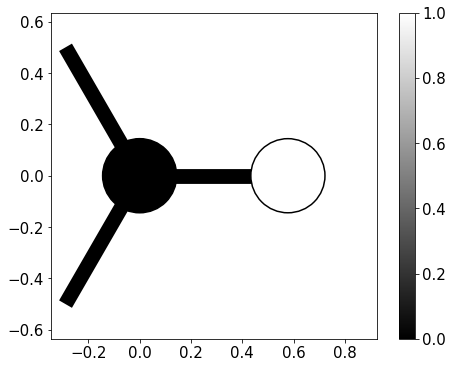

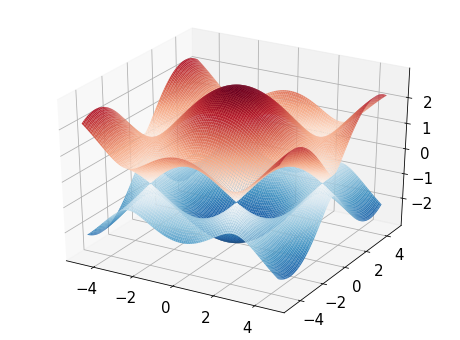

In [1]:
%run matplotlib_setup.ipy

from types import SimpleNamespace

from ipywidgets import interact
import matplotlib
from matplotlib import pyplot
from mpl_toolkits import mplot3d
import numpy as np
import scipy.linalg as la 

import kwant
from kwant.wraparound import wraparound, plot_2d_bands


def momentum_to_lattice(k):
    """Transform momentum to the basis of reciprocal lattice vectors.
    
    See https://en.wikipedia.org/wiki/Reciprocal_lattice#Generalization_of_a_dual_lattice
    """
    B = np.array(graphene.prim_vecs).T
    A = B.dot(np.linalg.inv(B.T.dot(B)))
    return np.linalg.solve(A, k)


def dispersion_2D(syst, args=None, lim=1.5*np.pi, num_points=200):
    """A simple plot of 2D band structure."""
    if args is None:
        args = []
    momenta = np.linspace(-lim, lim, num_points)
    energies = []
    for kx in momenta:
        for ky in momenta:
            lattice_k = momentum_to_lattice([kx, ky])
            h = syst.hamiltonian_submatrix(args=(list(args) + list(lattice_k)))
            energies.append(np.linalg.eigvalsh(h))
    
    energies = np.array(energies).reshape(num_points, num_points, -1)
    emin, emax = np.min(energies), np.max(energies)
    kx, ky = np.meshgrid(momenta, momenta)
    fig = pyplot.figure()
    axes = fig.add_subplot(1, 1, 1, projection='3d')
    for band in range(energies.shape[-1]):
        axes.plot_surface(kx, ky, energies[:, :, band], cstride=2, rstride=2,
                          cmap=matplotlib.cm.RdBu_r, vmin=emin, vmax=emax,
                          linewidth=0.1)
        
#Some helper functions to make the schematic look neat
def family_color(site): 
    if site.family == a: 
        return 0 
    else: 
        return 1
    
def hopping_lw(site1,site2): 
    return 0.1 if A in [site1.family,site2.family] else 0.05

graphene = kwant.lattice.general([[np.sqrt(3)/2,1/2],[np.sqrt(3)/2,-1/2]],  #Lattice vectors 
                                  [[0,0],[1/np.sqrt(3),0]]) # Co-ordinates
a,b = graphene.sublattices

bulk_graphene = kwant.Builder(kwant.TranslationalSymmetry(*graphene.prim_vecs))
bulk_graphene[graphene.shape((lambda pos: True), (0, 0))] = 0
bulk_graphene[graphene.neighbors(1)] = 1
kwant.plot(bulk_graphene,site_color=family_color,site_lw=0.01)
dispersion_2D(wraparound(bulk_graphene).finalized())

In [70]:
Zigzag = kwant.lattice.general([[1,0],[0,np.sqrt(3)/3]], #Lattice vectors
                                     [[1/6,0],[2/6,np.sqrt(3)/2],[4/6,np.sqrt(3)/2],[5/6,0]]) # Coordinates

#Zigzag = kwant.lattice.general([[2,0],[0,np.sqrt(3)/3]], #Lattice vectors
#                                     [[1/6,0],[2/6,np.sqrt(3)/2],[4/6,np.sqrt(3)/2],[5/6,0],
#                                     [7/6,0],[8/6,np.sqrt(3)/2],[10/6,np.sqrt(3)/2],[11/6,0]]) # Coordinates
def get_width(N=7): 
    if N < 2: 
        raise("N cannot be less than 2")
    else:
        return N/2*Zigzag.prim_vecs[1][1]+0.01

def make_1D_zigzag(N=7):
    syst = kwant.Builder(kwant.TranslationalSymmetry(Zigzag.prim_vecs[0]))
    syst[Zigzag.shape((lambda pos: pos[1] >0 and pos[1] <= get_width(N)),(0,0))] = 0
    syst[Zigzag.neighbors()] = -1
    return syst

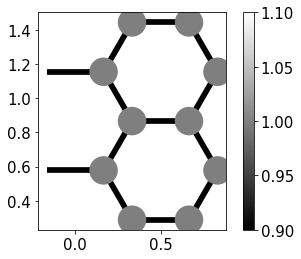

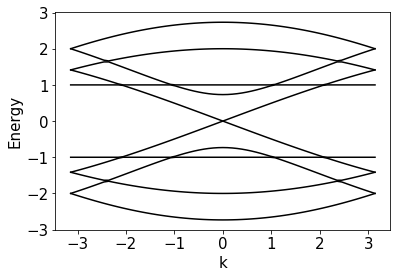


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-02-14 14:07:18,089                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(200, 500, 2)                               |
|        line:        <function <lambda> at 0x115cb87b8>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.0001                                           |
|        save_file:   None                        

In [73]:
N_list =[5]
#N_list =[12,13,14,15,16,17,18,19,20,21,22,23,24]
pol_N={}
wcc_N={}
import z2pack
from Z2_compute import zak_bands as zak_bands_z2
for N in N_list:
    # Making a Zigzag lead
    Zigzag_1d = make_1D_zigzag(N=N) 
    kwant.plot(Zigzag_1d,site_color=family_color);
    Zigzag_1d = Zigzag_1d.finalized()
    kwant.plotter.bands(Zigzag_1d);

    act_pos = np.array([Zigzag_1d.pos(i) for i in range(2*N)])
    a1,a2 = [Zigzag.prim_vecs[0][0],get_width(N=N)]
    red_pos = np.zeros(np.shape(act_pos))
    red_pos[:,0] = act_pos[:,0]/a1
    red_pos[:,1] = act_pos[:,1]/a2


    ham_k=zak_bands_z2(Zigzag_1d,momenta=1001,dim=2)
    z2_system = z2pack.hm.System(ham_k,dim=2,#pos=red_pos,
                                 convention=2)
    pol_sum = 0
    for n in range(0,1):
        result1 = z2pack.line.run(system=z2_system, 
                                 line=lambda t1: [t1,0],#,n/(N+1)])#,
                                 pos_tol=1e-4,
                                iterator=range(200,500,2));
    #np.exp(-1*2*np.pi*np.sum(np.log(np.diagonal(result.wilson))))
    #result.pol
        #result12 = z2pack.line.run(system=z2_system, 
        #                         line=lambda t1: [t1,-n/(N+1)],
        #                         pos_tol=1e-2)
        pol_sum += result1.pol
        #pol_sum += result2.pol
        
    
    pol_N[N] = np.sign(np.exp(1j*2*np.pi*(pol_sum % 1)))
    #pol_N[N] = np.exp(-1j*2*np.pi*(pol_sum % 1))
    wcc_N[N] = result1.wcc

In [74]:
result1.pol

0.24874646079283824

# TBModel

In [82]:
pos = []
for n in range(2*N): 
    pos.append(Zigzag_1d.pos(n))
on_site =  [0 for _ in range(2*N)]
red_pos = np.array(pos)
red_pos[:,0] /= Zigzag.prim_vecs[0][0]
red_pos[:,1] /= get_width(N)
extra_col = np.zeros((len(red_pos),1))
#red_pos = np.concatenate((red_pos,extra_col),axis=1)
import tbmodels
import itertools
nsites = len(red_pos)
model = tbmodels.Model(on_site=on_site,dim=2,occ=2*N,pos=red_pos)
t = -1
for i in range(nsites):
    for j in range(i+1,nsites):
        x1,y1 = pos[i]
        x2,y2 = pos[j]
        d = (x2-x1)**2 + (y2-y1)**2
        d = d**0.5
        if d < 2/6 + 0.1: 
            model.add_hop(t,i,j,[0,0])
        elif (x2-x1) > 0.5: 
            x2 = x2-1
            d = (x2-x1)**2 + (y2-y1)**2
            d = d**0.5
            if d < 2/6 + 0.1: 
                model.add_hop(t,i,j,[-1,0])
        elif (x2-x1) < -0.5:
            x2 = x2+1
            d = (x2-x1)**2 + (y2-y1)**2
            d = d**0.5
            if d < 2/6 + 0.1: 
                model.add_hop(t,i,j,[1,0])

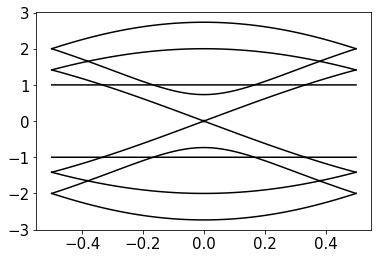

In [83]:
bands = []
k_list = np.linspace(-0.5,0.5,100)
for k in k_list:
    bands.append(model.eigenval(k=[k,0]))
plt.plot(k_list,np.array(bands));

In [77]:
model.hamilton(k=[0.5,0]) - ham_k([0.5])

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j]])

In [84]:
z2_system_tb = z2pack.tb.System(model,dim=2,convention=2,pos=red_pos)
result = z2pack.line.run(system=z2_system_tb, 
                                 line=lambda t1: [t1,1],#,n/(N+1)])#,
                                 pos_tol=1e-4,
                                 iterator=range(200,500,2))


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-02-14 14:08:14,610                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(200, 500, 2)                               |
|        line:        <function <lambda> at 0x1131e0ae8>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.0001                                           |
|        save_file:   None                        

In [81]:
np.sign(np.exp(-1j*2*np.pi*(result.pol % 1)))

(1+0j)

In [85]:
result.pol

0.0

# Zigzag'

In [10]:
Zigzag_dash = kwant.lattice.general([[1,0],[0,np.sqrt(3)/3]], #Lattice vectors
                                     [[1/6,0],[2/6,-np.sqrt(3)/2],[4/6,-np.sqrt(3)/2],[5/6,0]]) # Coordinates

def get_width_dash(N=7): 
    #if N < 2: 
        #raise("N cannot be less than 2")
    #else:
    return N/2*Zigzag_dash.prim_vecs[1][1]

def make_1D_zigzag_dash(N=7):
    syst = kwant.Builder(kwant.TranslationalSymmetry(Zigzag_dash.prim_vecs[0]))
    syst[Zigzag_dash.shape((lambda pos: pos[1] >-1*get_width_dash(1) and pos[1] <= get_width_dash(N-1)),(0,0))] = 0
    syst[Zigzag_dash.neighbors()] = -1
    return syst

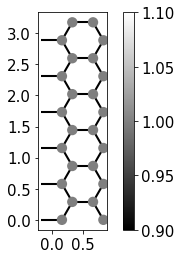

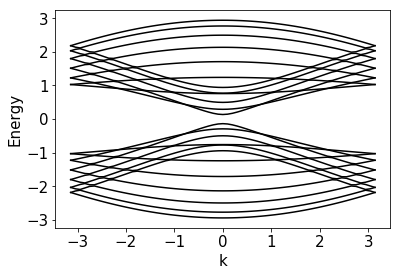


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-02-13 19:52:05,400                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(8, 27, 2)                                  |
|        line:        <function <lambda> at 0x11331dd08>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.001                                            |
|        save_file:   None                        

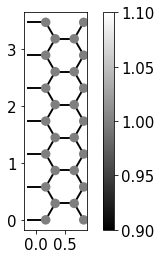

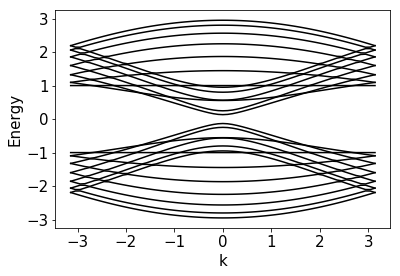


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-02-13 19:52:05,798                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(8, 27, 2)                                  |
|        line:        <function <lambda> at 0x11040e268>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.001                                            |
|        save_file:   None                        

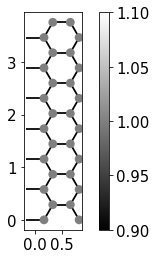

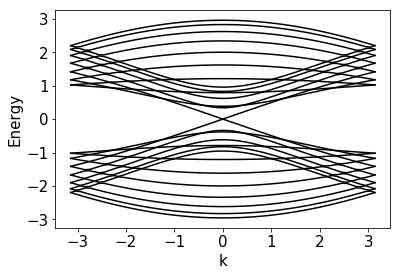


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-02-13 19:52:06,141                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(8, 27, 2)                                  |
|        line:        <function <lambda> at 0x11331dd08>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.001                                            |
|        save_file:   None                        

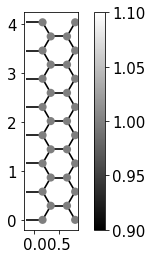

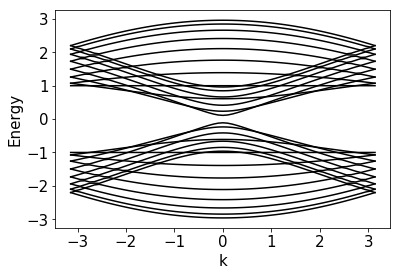


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-02-13 19:52:06,494                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(8, 27, 2)                                  |
|        line:        <function <lambda> at 0x114801730>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.001                                            |
|        save_file:   None                        

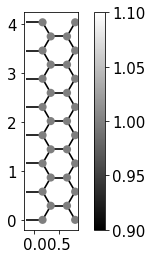

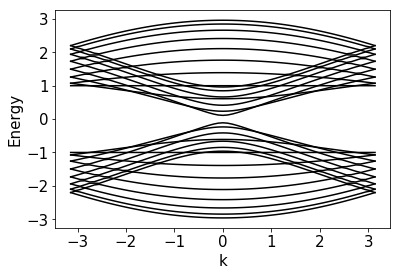


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-02-13 19:52:06,894                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(8, 27, 2)                                  |
|        line:        <function <lambda> at 0x11331dd08>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.001                                            |
|        save_file:   None                        

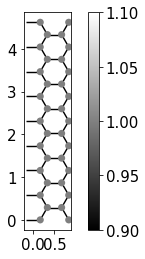

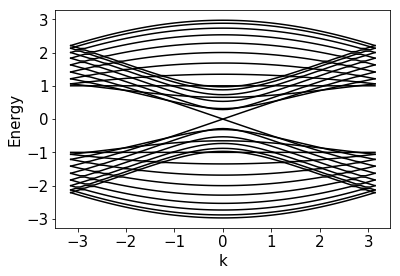


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-02-13 19:52:07,322                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(8, 27, 2)                                  |
|        line:        <function <lambda> at 0x114801730>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.001                                            |
|        save_file:   None                        

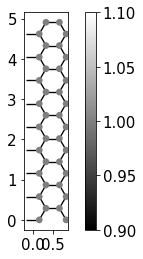

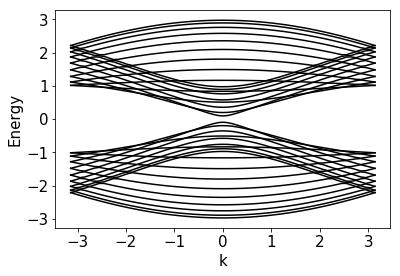


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-02-13 19:52:07,771                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(8, 27, 2)                                  |
|        line:        <function <lambda> at 0x1158056a8>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.001                                            |
|        save_file:   None                        

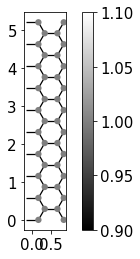

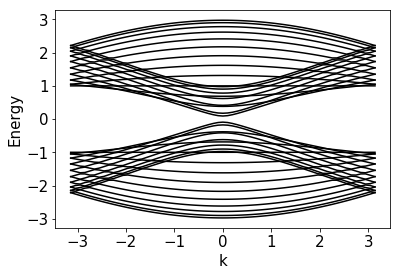


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-02-13 19:52:08,197                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(8, 27, 2)                                  |
|        line:        <function <lambda> at 0x10f7fe840>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.001                                            |
|        save_file:   None                        

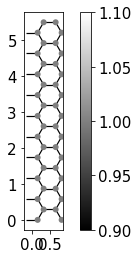

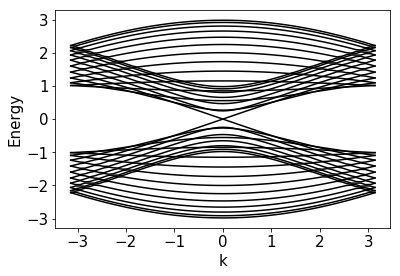


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-02-13 19:52:08,615                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(8, 27, 2)                                  |
|        line:        <function <lambda> at 0x11558fe18>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.001                                            |
|        save_file:   None                        

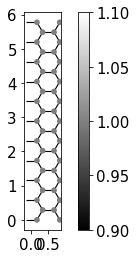

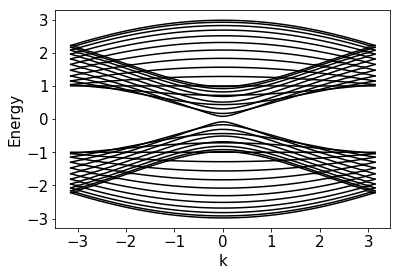


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-02-13 19:52:09,090                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(8, 27, 2)                                  |
|        line:        <function <lambda> at 0x115315e18>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.001                                            |
|        save_file:   None                        

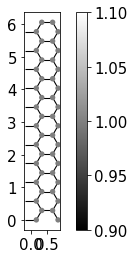

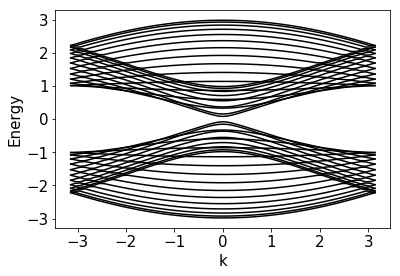


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-02-13 19:52:09,591                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(8, 27, 2)                                  |
|        line:        <function <lambda> at 0x11558fe18>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.001                                            |
|        save_file:   None                        

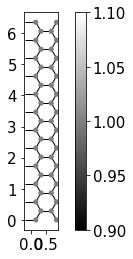

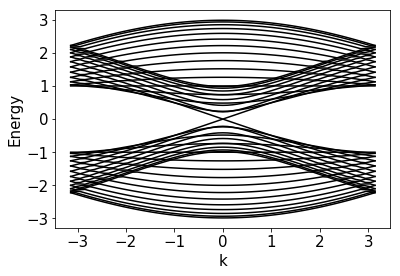


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-02-13 19:52:10,019                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(8, 27, 2)                                  |
|        line:        <function <lambda> at 0x115315e18>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.001                                            |
|        save_file:   None                        

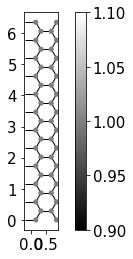

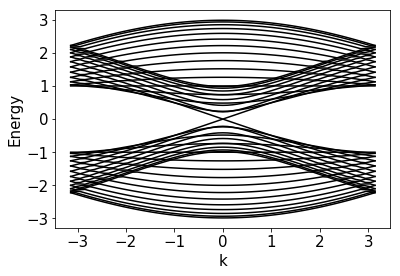


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-02-13 19:52:10,526                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(8, 27, 2)                                  |
|        line:        <function <lambda> at 0x1103fed08>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.001                                            |
|        save_file:   None                        

In [11]:
#N_list =[3,11,5,7,9,8,10,2,4,6]
N_list =[12,13,14,15,16,17,18,19,20,21,22,23,24]

pol_N={}
import z2pack
from Z2_compute import zak_bands as zak_bands_z2
for N in N_list:
    # Making a Zigzag lead
    Zigzag_1d_dash = make_1D_zigzag_dash(N=N) 
    kwant.plot(Zigzag_1d_dash,site_color=family_color);
    Zigzag_1d_dash = Zigzag_1d_dash.finalized()
    kwant.plotter.bands(Zigzag_1d_dash);

    #act_pos = np.array([Zigzag_1d_dash.pos(i) for i in range(2*N)])
    #a1,a2 = [Zigzag_dash.prim_vecs[0][0],get_width(N=N)]
    #red_pos = np.zeros(np.shape(act_pos))
    #red_pos[:,0] = act_pos[:,0]/a1
    #red_pos[:,1] = act_pos[:,1]/a2


    ham_k=zak_bands_z2(Zigzag_1d_dash,momenta=1001,dim=1)
    z2_system = z2pack.hm.System(ham_k,dim=1,#pos=red_pos,
                                 convention=2)
    pol_sum = 0
    for n in range(0,1):
        result1 = z2pack.line.run(system=z2_system, 
                                 line=lambda t1: [t1],#,n/(N+1)])#,
                                 pos_tol=1e-3)#,iterator=range(200,500,2));
    #np.exp(-1*2*np.pi*np.sum(np.log(np.diagonal(result.wilson))))
    #result.pol
        #result12 = z2pack.line.run(system=z2_system, 
        #                         line=lambda t1: [t1,-n/(N+1)],
        #                         pos_tol=1e-2)
        pol_sum += result1.pol
        #pol_sum += result2.pol
        
    
    pol_N[N] = pol_sum % 1
    z2 = np.sign(np.exp(1j*2*np.pi*pol_N[N]))

In [12]:
z2

(1+0j)

## Bearded

In [13]:
Bearded = kwant.lattice.general([[1,0],[0,np.sqrt(3)/3]], #Lattice vectors
                                     [[0.5/6,np.sqrt(3)/2],[2.5/6,np.sqrt(3)/2],[3.5/6,0],[5.5/6,0]]) # Coordinates

def get_width(N=7): 
    if N < 2: 
        raise("N cannot be less than 2")
    else:
        return N/2*Zigzag.prim_vecs[1][1]+0.01

def make_1D_bearded(N=7):
    syst = kwant.Builder(kwant.TranslationalSymmetry(Bearded.prim_vecs[0]))
    syst[Bearded.shape((lambda pos: pos[1] >0 and pos[1] <= get_width(N)),(0,0))] = 0
    syst[Bearded.neighbors()] = -1
    return syst

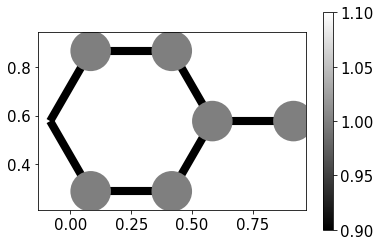

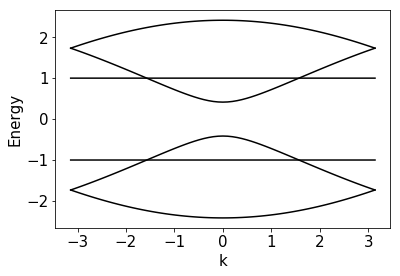


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-02-13 19:52:10,979                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(8, 27, 2)                                  |
|        line:        <function <lambda> at 0x1147a7e18>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.01                                             |
|        save_file:   None                        

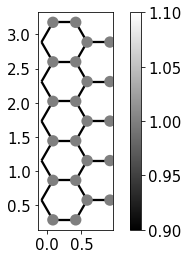

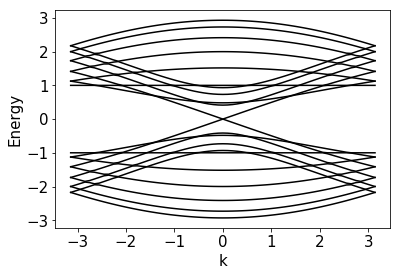


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-02-13 19:52:11,285                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(8, 27, 2)                                  |
|        line:        <function <lambda> at 0x115315e18>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.01                                             |
|        save_file:   None                        

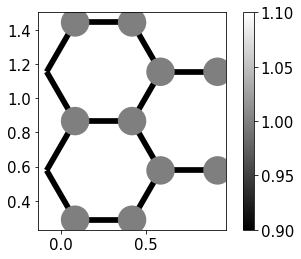

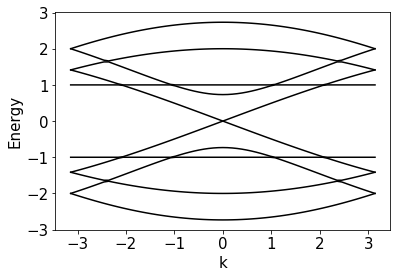


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-02-13 19:52:11,573                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(8, 27, 2)                                  |
|        line:        <function <lambda> at 0x1147a7e18>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.01                                             |
|        save_file:   None                        

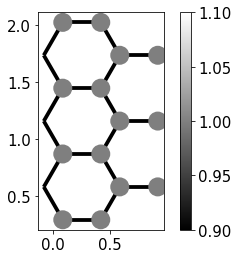

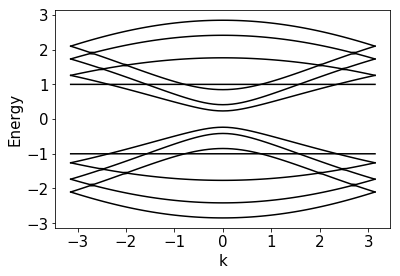


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-02-13 19:52:11,894                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(8, 27, 2)                                  |
|        line:        <function <lambda> at 0x1153f81e0>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.01                                             |
|        save_file:   None                        

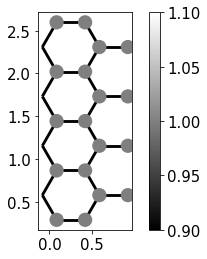

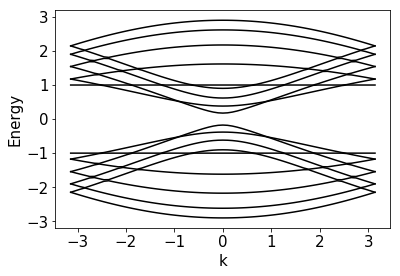


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-02-13 19:52:12,188                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(8, 27, 2)                                  |
|        line:        <function <lambda> at 0x1153f8bf8>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.01                                             |
|        save_file:   None                        

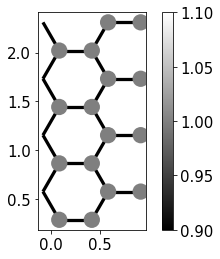

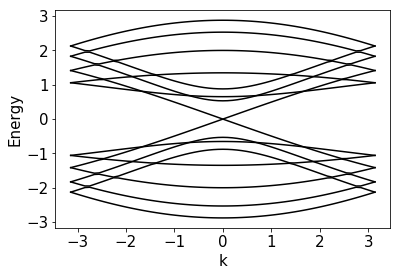


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-02-13 19:52:12,469                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(8, 27, 2)                                  |
|        line:        <function <lambda> at 0x1153f8730>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.01                                             |
|        save_file:   None                        

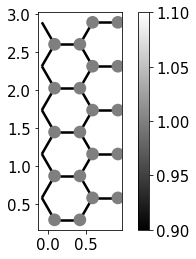

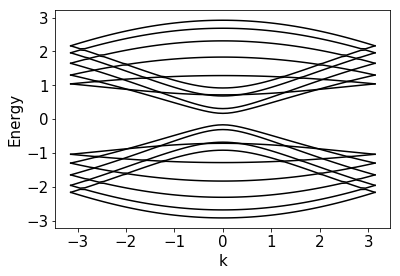


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-02-13 19:52:12,767                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(8, 27, 2)                                  |
|        line:        <function <lambda> at 0x10ef64d08>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.01                                             |
|        save_file:   None                        

ValueError: No sites close to (0, 0) are inside the desired shape.

In [14]:
N_list =[3,11,5,7,9,8,10,2,4,6]
pol_N={}
import z2pack
from Z2_compute import zak_bands as zak_bands_z2
for N in N_list:
    # Making a Zigzag lead
    beard_1d = make_1D_bearded(N=N) 
    kwant.plot(beard_1d,site_color=family_color);
    beard_1d = beard_1d.finalized()
    kwant.plotter.bands(beard_1d);

    act_pos = np.array([beard_1d.pos(i) for i in range(2*N)])
    a1,a2 = [Bearded.prim_vecs[0][0],get_width(N=N)]
    red_pos = np.zeros(np.shape(act_pos))
    red_pos[:,0] = act_pos[:,0]/a1
    red_pos[:,1] = act_pos[:,1]/a2


    ham_k=zak_bands_z2(beard_1d,momenta=1001,dim=1)
    z2_system = z2pack.hm.System(ham_k,dim=1,#pos=red_pos,
                                 convention=2)
    pol_sum = 0
    for n in range(0,1):
        result1 = z2pack.line.run(system=z2_system, 
                                 line=lambda t1: [t1])#,n/(N+1)])#,
                                 #pos_tol=1e-3,iterator=range(200,500,2));
    #np.exp(-1*2*np.pi*np.sum(np.log(np.diagonal(result.wilson))))
    #result.pol
        #result12 = z2pack.line.run(system=z2_system, 
        #                         line=lambda t1: [t1,-n/(N+1)],
        #                         pos_tol=1e-2)
        pol_sum += result1.pol
        #pol_sum += result2.pol
        
    
    pol_N[N] = np.sign(np.exp(-1j*2*np.pi*(pol_sum % 1)))

In [ ]:
pol_N

## Validate Hamiltonian band structure

## TB Model

In [ ]:
import tbmodels